In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

In [29]:
# Read Files
df_country = pd.read_csv("HNP_StatsCountry.csv") # Country and Region Data
df_data = pd.read_csv("HNP_StatsData.csv") # All Relevant Statistics

In [ ]:
"""
# see how much of data is missing for each indicator and year
year_cols = [col for col in df_data.columns if col not in ["Indicator Name","Indicator Code","Country Code","Unnamed: 66"]]

for ind in df_data['Indicator Name'].unique():    
    # Missing ratio
    missing_cnt = df_data[df_data['Indicator Name'] == ind][year_cols].isna().sum() / len(df_data[df_data['Indicator Name'] == ind]) 
    print(ind, missing_cnt)
"""

In [31]:
# year columns 
year_cols = [col for col in df_data.columns if col not in ["Indicator Name","Indicator Code","Country Code","Unnamed: 66"]]

# List of Continents
continents = ['Africa Eastern and Southern', 'Africa Western and Central',
       'Arab World', 'Caribbean small states',
       'Central Europe and the Baltics', 
       'East Asia & Pacific',
       #'East Asia & Pacific (excluding high income)',
       #'East Asia & Pacific (IDA & IBRD countries)', 'Euro area',
       'Europe & Central Asia',
       #'Europe & Central Asia (excluding high income)',
       #'Europe & Central Asia (IDA & IBRD countries)', 'European Union',
       'Latin America & Caribbean',
       #'Latin America & Caribbean (excluding high income)',
       #'Latin America & the Caribbean (IDA & IBRD countries)',
       'Middle East & North Africa',
       #'Middle East & North Africa (excluding high income)',
       #'Middle East & North Africa (IDA & IBRD countries)',
       'North America',
       'South Asia',
       #'South Asia (IDA & IBRD)',
       'Sub-Saharan Africa',
       #'Sub-Saharan Africa (excluding high income)',
       #'Sub-Saharan Africa (IDA & IBRD countries)'
       ]
# List of Countries
countries = [col for col in df_data['Country Name'].unique() if col not in continents]
countries = countries[countries.index("Afghanistan"):]


In [32]:
"""
Original df has year as different columns.
Transpose and rearrange the DataFrame, so that we have country, year and value as columns.
"""
def df_rearrange(df, col_name, country_group):

    df_res = df_data[(df_data['Country Name'].isin(country_group))
            & (df_data['Indicator Name'] == col_name)]

    # Rearrange df 
    year_cols = [col for col in df_data.columns if col not in ["Indicator Name"
                                                               ,"Indicator Code","Country Code","Unnamed: 66"]]
    df_res = df_res[year_cols].T

    column_names = df_res.iloc[0].tolist()

    df_res = df_res.iloc[1:]
    df_res.columns = column_names
    df_res.reset_index(level=0, inplace=True)
    df_res.rename(columns={'index':'Year'}, inplace=True)
    df_res.set_index('Year', inplace=True)

    # Drop year 2020 and 2021, because values are missing
    #df_res.drop(['2020','2021'], inplace=True)

    df_res.reset_index(inplace=True)
    df_res = pd.melt(df_res, id_vars='Year')
    df_res.rename(columns={"variable":"Region"}, inplace=True)
    
    return df_res

# Rearrange multiple columns into a single df 
def df_rearrange_multiple(df, col_list, country_group):
    
    df_res = df_rearrange(df, col_list[0], country_group)
    df_res.rename(columns={'value':col_list[0]}, inplace=True)
    
    for col in col_list[1:]:
        df_tmp = df_rearrange(df, col, country_group)
        df_tmp.rename(columns={'value':col}, inplace=True)
        df_res = df_res.merge(df_tmp, on=['Year','Region'], how='left')
    
    return df_res


### Infant Mortality Rate & Fertility Rate
* Let's look at regional & global scope

In [33]:
# Plot fertility by continents
df_fertility_continents = df_rearrange(df_data, 'Fertility rate, total (births per woman)', continents)

fig = px.line(df_fertility_continents, x="Year", y="value", color="Region"
            , title="Fertility per birthwoman", labels={"value":"Fertility per Birth Woman"})
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    title_x=0.25,
    title_font_size=24
)
fig.update_yaxes(range=[0, 8])
fig.show()

# Mortality
df_mortality_continents = df_rearrange(df_data,  'Mortality rate, infant (per 1,000 live births)', continents)
df_mortality_continents['Year'] = df_fertility_continents['Year'].astype('int64')

fig = px.line(df_mortality_continents, x="Year", y="value", color="Region", title="Infant Mortality Rate (per thousand)")
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    title_x=0.25,
    title_font_size=24
)
fig.update_xaxes(range=[1990, 2018])
fig.update_yaxes(range=[0, 150])

fig.show()


It looks like fertility rate has been on a downward trend for last few decades. Let's take a look at global numbers.

In [34]:
df_mortality_global = df_rearrange(df_data, 'Mortality rate, infant (per 1,000 live births)', ['World'])
df_mortality_global.rename(columns={"value":"Mortality"}, inplace=True)
df_fertility_global = df_rearrange(df_data, 'Fertility rate, total (births per woman)', ['World'])
df_fertility_global.rename(columns={"value":"Fertility"}, inplace=True)
df_res = df_mortality_global.merge(df_fertility_global, on=['Year','Region'], how='left')

# Plot
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df_res['Year'], y=df_res['Mortality'], mode='markers+lines', name='Mortality'))
fig.add_trace(go.Scatter(x=df_res['Year'], y=df_res['Fertility'], mode='markers+lines', name='Fertility'), secondary_y=True)

# Set x-axis title
fig.update_xaxes(title_text="Year")

# Set y-axes titles
fig.update_yaxes(title_text="Infant Mortality (per thousand)", secondary_y=False)
fig.update_yaxes(title_text="Fertility (per birthwoman)", secondary_y=True)

# Set y-axes ranges
fig.update_layout(yaxis_range=[20,70], title_text="Global Mortality & Fertility", width=1000
                , height=500,title_x=0.3, title_font_size=24)
fig.update_layout(yaxis2 = dict(range=[2,6]))

fig.show()


### Effect of government health expenditure per capita and population on infant mortality
The infant mortality rate may serve as benchmarks of health wellness and welfare. There should be a correlation between how much the government spends on people's health and the mortality rate. Let's find out. 

In [35]:
# Create and Merge all necessary columns 
df_mortality_countries = df_rearrange(df_data, 'Mortality rate, infant (per 1,000 live births)', countries)
df_mortality_countries.rename(columns={"value":"Mortality"}, inplace=True)

df_health_expenditure = df_rearrange(df_data, 'Domestic general government health expenditure per capita (current US$)', countries)
df_health_expenditure.rename(columns={"value":"Expenditure ($)"}, inplace=True)

df_population = df_rearrange(df_data, 'Population, total', countries)
df_population.rename(columns={"value":"Population"}, inplace=True)

df_merged = df_mortality_countries.merge(df_health_expenditure, on=['Year','Region'], how='left') \
        .merge(df_population, on=['Year','Region'], how='left')

# Only select year 2018
df_res = df_merged[df_merged["Year"] == "2018"]

# Drop any rows with NaN
df_res.dropna(inplace=True)

# Change region column into country column
df_res.rename(columns={"Region":"Country"}, inplace=True)

# Add region(continent) for each country
df_country_region = df_country[['Table Name','Region']]
df_country_region.rename(columns={'Table Name':'Country'}, inplace=True)
df_res = df_res.merge(df_country_region, on=['Country'],how='left')
df_res['Region'].fillna("Other", inplace=True)

# Convert into float values
df_res.loc[:,'Mortality'] = df_res['Mortality'].astype('float64')

# Plot
fig = px.scatter(df_res, x="Expenditure ($)", y="Population", size="Mortality", 
                 hover_name="Country", color="Region", log_x=True, log_y=True)

fig.update_layout(
    title="Infant Mortality Rate by Countries (2018)",
    title_x=0.43, 
    title_font_size=24,
    xaxis_title="Government Health Expenditure per Capita ($)",
    yaxis_title="Population",
    font=dict(
        size=14,
    )
)

fig.show()


C:\Users\leeja\anaconda3\envs\py37\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\leeja\anaconda3\envs\py37\lib\site-packages\pandas\core\frame.py:5047: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We can observe a direct correlation between health expenditures and infant mortality. (The circles get smaller as we move along the x-axis towards right.) 

### Demographics Changes ###

Both infant mortality and fertility rates have been decreasing sharply over decades. How would these affect the population % by each age bracket in each region?

In [36]:
# Population columns
population_col_list = ['Population ages 00-14, total', 'Population ages 15-19, male', 'Population ages 15-19, female',
                       'Population ages 20-24, female', 'Population ages 20-24, male' ,'Population ages 25-29, female',
                       'Population ages 25-29, male', 'Population ages 30-34, female', 'Population ages 30-34, male',
                       'Population ages 35-39, female', 'Population ages 35-39, male', 'Population ages 40-44, female',
                       'Population ages 40-44, male', 'Population ages 45-49, female', 'Population ages 45-49, male',
                       'Population ages 50-54, female', 'Population ages 50-54, male', 'Population ages 55-59, female',
                       'Population ages 55-59, male', 'Population ages 60-64, female', 'Population ages 60-64, male',
                       'Population ages 65 and above, female', 'Population ages 65 and above, male']

# All population columns rearranged
df_population = df_rearrange_multiple(df_data, population_col_list, countries)

# There are separate male and female groups. Combine into one age group.
population_columns = df_population.columns

for i in range(3, len(population_columns), 2):
    df_population[population_columns[i].split(",")[0]] = df_population[population_columns[i]] + df_population[population_columns[i+1]]
    df_population.drop([population_columns[i],population_columns[i+1]], axis=1, inplace=True)

df_population[population_col_list[0].split(",")[0]] = df_population[population_col_list[0]]
df_population.drop([population_col_list[0]], axis=1, inplace=True)

# Drop any rows with entry zero
df_population.dropna(inplace=True)

# Reorganize age columns into one column
df_population = pd.melt(df_population, id_vars=['Year','Region'])
df_population.rename(columns={'Region':'Country', 'variable':'Age Group', 'value':'Population'}, inplace=True)

# Add the continents to each country
df_country_region = df_country[['Table Name','Region']]
df_country_region.rename(columns={'Table Name':'Country'}, inplace=True)
df_population = df_population.merge(df_country_region, on=['Country'],how='left')
df_population['Region'].fillna("Other", inplace=True)

# Group df_population by region and calculate ratio of population that each age group occupies
df_population_region = pd.DataFrame(df_population.groupby(['Year','Region','Age Group'])['Population'].sum())
df_population_region = df_population_region.groupby(level=['Year','Region']).apply(lambda x: x / float(x.sum()))
df_population_region.reset_index(inplace=True)
df_population_region.rename(columns={'Population':'Population Ratio'}, inplace=True)

display(df_population_region.head(20))

,Year,Region,Age Group,Population Ratio
0,1960,East Asia & Pacific,Population ages 00-14,0.393015
1,1960,East Asia & Pacific,Population ages 15-19,0.086223
2,1960,East Asia & Pacific,Population ages 20-24,0.081731
3,1960,East Asia & Pacific,Population ages 25-29,0.076279
4,1960,East Asia & Pacific,Population ages 30-34,0.06666
5,1960,East Asia & Pacific,Population ages 35-39,0.058142
6,1960,East Asia & Pacific,Population ages 40-44,0.053826
7,1960,East Asia & Pacific,Population ages 45-49,0.047672
8,1960,East Asia & Pacific,Population ages 50-54,0.039746
9,1960,East Asia & Pacific,Population ages 55-59,0.033201


In [37]:
region_list = list(df_population_region['Region'].unique())
region_list.remove('Other')

for region in region_list:
    fig = px.bar(df_population_region[df_population_region['Region'] == region], x="Year", y="Population Ratio"
                 , color="Age Group", title=region+" Population % by Age Groups")
    
    fig.update_yaxes(title_text="Population %")
    fig.update_layout(
        yaxis = dict(
            tickformat = ',.2%'
        ), 
        font=dict(
            size=14,
        ),
        title_x=0.2,
        title_font_size=20
    )

    fig.show()

Except for Africa, we can observe a consistent decrease in the % of young population. This may be attributed to the decrease in the birthrate, as well as greater life expectancy.

### South Korea's Greatest Concern
Let's narrow down the scope to the national level. One of the most concerning social challenges in South Korea is the sharp decline in birthrate, which has marked the lowest in the world in recent studies. The gloom of aged society, lack of labor forces and subsequent loss of developmental momentum has never loomed larger than now; let's try to visuazlie the correlation between the birthrate and young population changes.

* Age dependency ratio
* Population Change
* Fertility

Text(0.5, 1.0, 'Correlation Matrix')

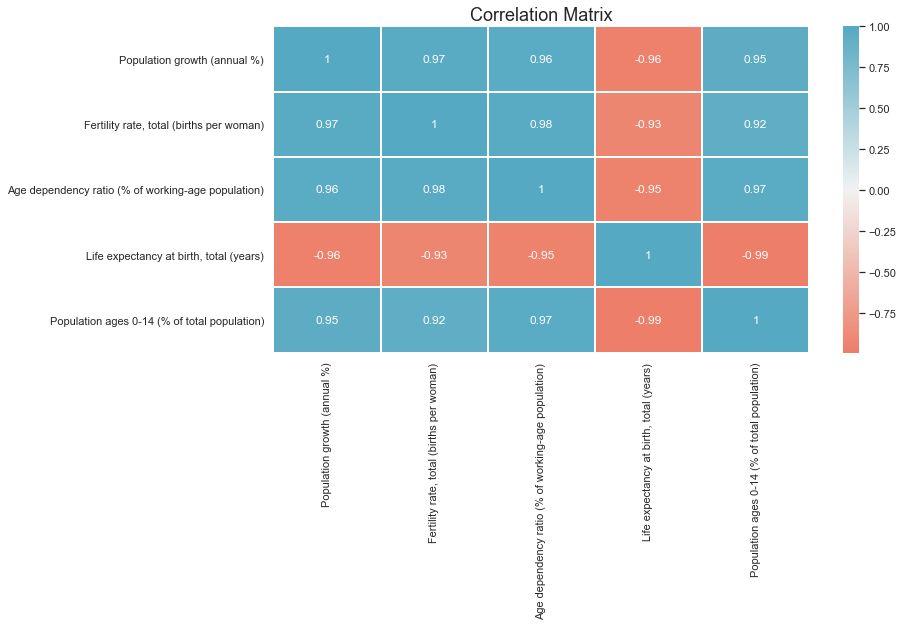

In [38]:
col_list = ['Population growth (annual %)', 'Fertility rate, total (births per woman)'
            , 'Age dependency ratio (% of working-age population)', 'Life expectancy at birth, total (years)'
            , 'Population ages 0-14 (% of total population)']

# Korea Data
df_kor = df_rearrange_multiple(df_data, col_list, ['Korea, Rep.'])

# Until 2019
df_kor = df_kor.iloc[:-2]
df_kor[col_list] = df_kor[col_list].astype('float64')

sns.set_theme(style="white")
corr = df_kor.corr()
cmap = sns.diverging_palette(20, 220, as_cmap=True, l=65)

plt.figure(figsize=(12, 6))

heatmap = sns.heatmap(corr, linewidth=0.1, cmap=cmap, annot=True)
heatmap.set_title("Correlation Matrix", fontdict={'fontsize':18})

In [39]:
"""
Make plots of Population Growth % vs. Fertility Rates over Years
"""
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=df_kor['Year'], y=df_kor['Population growth (annual %)']/100, name='Population Change %'))

fig.add_trace(go.Scatter(
    x=df_kor['Year'],
    y=df_kor['Fertility rate, total (births per woman)']/100,
    name="Fertility Rate"
    ), secondary_y=True)

fig.update_layout(
    yaxis = dict(
            tickformat = ',.2%'),
    yaxis2 = dict(
            tickformat = ',.2%'),
    autosize=False,
    width=1000,
    height=500,
    title_text="Population Growth % vs. Fertility Rate",
    title_x=0.2,
    title_font_size=24
)

# Set x-axis title
fig.update_xaxes(title_text="Year")

# Set y-axes titles
fig.update_yaxes(title_text="Population Growth %", secondary_y=False)
fig.update_yaxes(title_text="Fertility Rate (per thousand)", secondary_y=True)

fig.show()

#### Using Linear Regression to Anticipate Age Dependency Ratio by 2030